In [72]:
# !pip install livelossplot --quiet

In [73]:
# #If you want to load your dataset from google drive, uncomment the following codes

# from google.colab import files
# from google.colab import drive
# #Mounting Google Drive
# drive.mount('/content/drive')
# #%unload_ext google.colab.data_table

In [74]:
#Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
%matplotlib inline
sns.set()
import matplotlib as mpl
mpl.style.use('classic')
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)
mpl.rcParams['font.size'] = 8

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns  # For plotting confusion matrix
from tqdm import tqdm as tqdm # look at Lab 3 for usage. If not installed, use !pip3 install tqdm
from livelossplot import PlotLosses # look at Lab 3 for usage. If not installed, use !pip install livelossplot --quiet

#Loading OP DataSet from Google Drive
df = pd.read_excel('/content/drive/MyDrive/CEE598DL/Data.xlsx') #Loaded from my own google drive
df = df.fillna(0)
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Scattering_Angle_for_Nominal_Azimuth_Angle(Degrees).68,Scattering_Angle_for_Nominal_Azimuth_Angle(Degrees).69,Scattering_Angle_for_Nominal_Azimuth_Angle(Degrees).70,Scattering_Angle_for_Nominal_Azimuth_Angle(Degrees).71,Scattering_Angle_for_Nominal_Azimuth_Angle(Degrees).72,Scattering_Angle_for_Nominal_Azimuth_Angle(Degrees).73,Scattering_Angle_for_Nominal_Azimuth_Angle(Degrees).74,Scattering_Angle_for_Nominal_Azimuth_Angle(Degrees).75,Scattering_Angle_for_Nominal_Azimuth_Angle(Degrees).76,Unnamed: 164
0,Day_of_Year,Day,Month,Year,Hour,Minute,Second,Nominal_Wavelength(nm),Exact_Wavelength(um),Solar_Zenith_Angle(Degrees),...,-2.500000,-2.000000,2.000000,2.500000,3.000000,3.500000,4.000000,5.000000,6.000000,Dust
1,176,24,6,2000,9,25,40,1020,1.0216,53.549384,...,-2.010867,-1.608710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.825437,0
2,312,25,6,2000,9,25,40,1020,1.0216,60.592342,...,-2.177829,-1.742275,0.000000,2.177829,2.613373,3.048904,3.484422,4.355408,5.226313,0
3,315,26,6,2000,9,25,40,1020,1.0216,76.089187,...,-2.426667,-1.941337,1.941337,2.426667,2.911994,3.397318,3.882639,4.853267,5.823873,0
4,80,27,6,2000,9,25,40,1020,1.0216,74.949872,...,-2.414235,-1.931391,0.000000,2.414235,2.897075,3.379911,3.862743,4.828392,5.794015,0


In [75]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [76]:
data = df.to_numpy()
#data = np.reshape(4759,1,169)
data1 = data[2:-1,0:-1].astype(float)
label = data[2:-1, -1].astype(float).reshape(4756)
data1.shape

(4756, 164)

In [77]:
X_trainval, X_test, y_trainval, y_test = train_test_split(data1, label, test_size=0.3, random_state=42)


In [78]:
# # Split the dataset into training and validation sets with shuffling
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.14, shuffle=True)

# Convert arrays back to tensors for training with PyTorch
X_train = torch.tensor(X_train, dtype=torch.float)
X_val = torch.tensor(X_val, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [79]:
from tqdm import tqdm as tqdm

learningRate = 1e-3  # Single learning rate for this lab.

# Definition of our network.
network = nn.Sequential(
    nn.Linear(164, 64),
    nn.ReLU(),
    nn.Linear(64, 3),
)
#Definition of our loss.
criterion = nn.CrossEntropyLoss()

# Definition of optimization strategy.
optimizer = optim.SGD(network.parameters(), lr = learningRate)

def train_model(network, criterion, optimizer, trainLoader, valLoader, num_epochs = 10):
    # Training loop.
    # Training loop with validation
  liveloss = PlotLosses()
  model = network

  for epoch in range(num_epochs):
    model.train()
    logs = {}
    running_loss, correct, total= 0.0, 0, 0
    t = tqdm(train_loader, desc = 'Training epoch %d' % epoch)

    for (i,(inputs, labels)) in enumerate(t):
        inputs, labels = inputs, labels
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        train_accuracy = correct / total
        t.set_postfix(train_loss=running_loss / len(train_loader), train_accuracy=train_accuracy)

    logs['loss'] = running_loss / len(train_loader)
    logs['accuracy'] = train_accuracy


    # Validation
    model.eval()
    val_running_loss, correct, total = 0.0, 0, 0
    t = tqdm(val_loader, desc = 'Validation epoch %d' % epoch)
    with torch.no_grad():
        for (i, (inputs, labels)) in enumerate(t):
            inputs, labels = inputs, labels
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            val_accuracy = correct / total
            t.set_postfix(val_loss=val_running_loss / len(val_loader), val_accuracy=val_accuracy)

    logs['val_loss'] = val_running_loss / len(val_loader)
    logs['val_accuracy'] = val_accuracy

    # Update the plot with new logging information.
    liveloss.update(logs)
    liveloss.send()



count_params = 0
for param in network.parameters():
  count_params += param.numel()
print(count_params)

10755


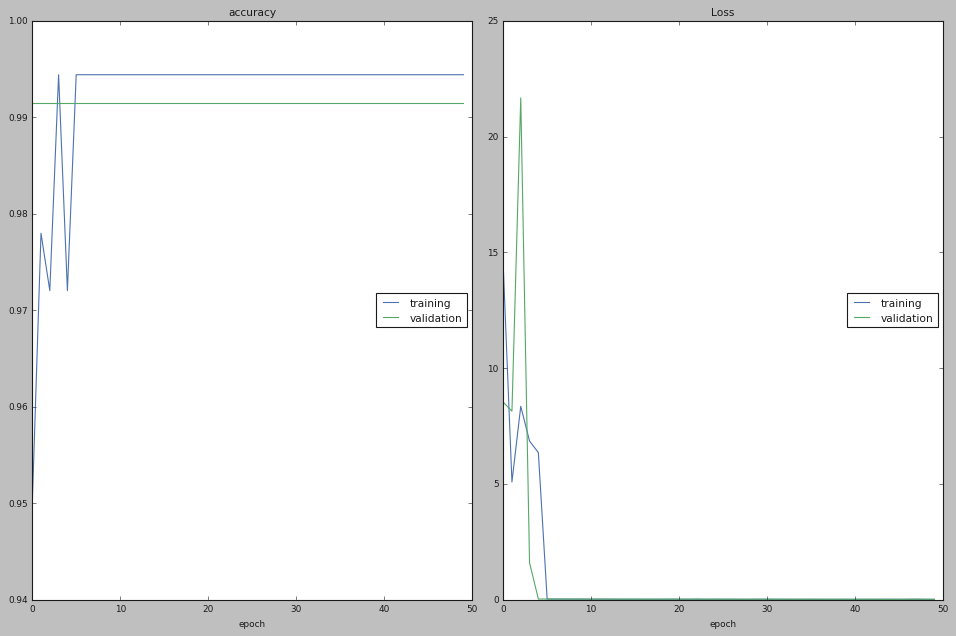

accuracy
	training         	 (min:    0.950, max:    0.994, cur:    0.994)
	validation       	 (min:    0.991, max:    0.991, cur:    0.991)
Loss
	training         	 (min:    0.030, max:   14.532, cur:    0.031)
	validation       	 (min:    0.027, max:   21.668, cur:    0.027)


In [80]:
# Train the previously defined model.
train_model(network, criterion, optimizer, train_loader, val_loader, num_epochs = 50)


In [81]:
network.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = network(X_test)
    _, predicted = torch.max(outputs, 1)
    test_accuracy = accuracy_score(y_test.cpu().numpy(), predicted.cpu().numpy())

# Calculate and print test accuracy
print(f'Test Accuracy: {test_accuracy*100 :.2f}%')

Test Accuracy: 99.37%


In [82]:
y_test

tensor([0, 0, 0,  ..., 0, 0, 1])

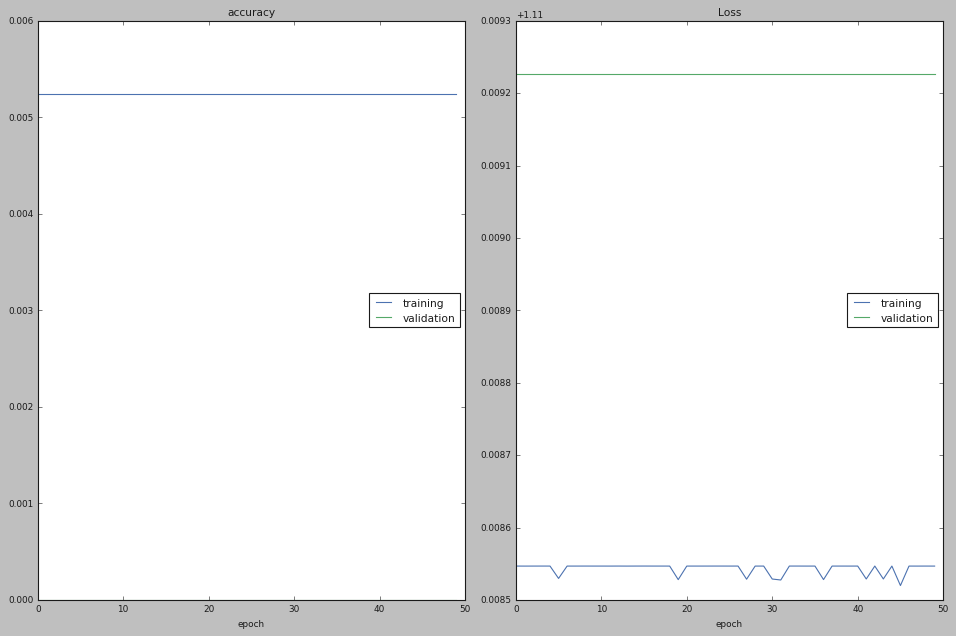

accuracy
	training         	 (min:    0.005, max:    0.005, cur:    0.005)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    1.119, max:    1.119, cur:    1.119)
	validation       	 (min:    1.119, max:    1.119, cur:    1.119)


In [83]:
data2 = df.to_numpy()
#data = np.reshape(4759,1,169)
data1 = data2[2:-1,0:-1].astype(float).reshape(4756,164,1)
label = data2[2:-1, -1].astype(float).reshape(4756)
data1.shape

X_trainval, X_test, y_trainval, y_test = train_test_split(data1, label, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.14, random_state=42)

# Convert arrays back to tensors for training with PyTorch
X_train = torch.tensor(X_train, dtype=torch.float)
X_val = torch.tensor(X_val, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


# RNN model definition
class DustClassifierRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DustClassifierRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :] # Get the last sequence output
        out = F.relu(self.fc(out))
        return out

# Model Initialization
model = DustClassifierRNN(input_size=1, hidden_size=64, output_size=3)
#Definition of our loss.
criterion = nn.CrossEntropyLoss()

# Definition of optimization strategy.
optimizer = optim.SGD(network.parameters(), lr = learningRate)

train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs = 50)

In [84]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    test_accuracy = accuracy_score(y_test.cpu().numpy(), predicted.cpu().numpy())

# Calculate and print test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 0.35%
